In [1]:
# Copyright (c) MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Using ControlNet to control image generation

This tutorial illustrates how to use MONAI Generative Models to train a ControlNet [1]. ControlNets are hypernetworks that allow for supplying extra conditioning to ready-trained diffusion models. In this example, we will walk through training a ControlNet that allows us to specify a whole-brain mask that the sampled image must respect.



In summary, the tutorial will cover the following:
1. Loading and preprocessing a dataset (we extract the brain MRI dataset 2D slices from 3D volumes from the BraTS dataset)
2. Training a 2D diffusion model
3. Freeze the diffusion model and train a ControlNet
3. Conditional sampling with the ControlNet

[1] - Zhang et al. [Adding Conditional Control to Text-to-Image Diffusion Models](https://arxiv.org/abs/2302.05543)

## Setup environment

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

In [2]:
import os
import tempfile
import time
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from monai import transforms
from monai.apps import DecathlonDataset
from monai.config import print_config
from monai.data import DataLoader
from monai.utils import first, set_determinism
from torch.cuda.amp import GradScaler, autocast
from tqdm import tqdm

from datetime import datetime 
from pathlib import Path
import pandas as pd
import sys
import imageio
from PIL import Image
from torch.utils.data import DataLoader
from torchvision import models, transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image, make_grid
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter
from torchvision.transforms import Compose, ToTensor, Lambda, RandomAffine, ColorJitter, RandomHorizontalFlip 
from sklearn.model_selection import train_test_split


from generative.inferers import DiffusionInferer
from generative.networks.nets import DiffusionModelUNet, ControlNet
from generative.networks.schedulers import DDPMScheduler

from monai.data import Dataset
from generative.inferers import LatentDiffusionInferer
from generative.losses.adversarial_loss import PatchAdversarialLoss
from generative.losses.perceptual import PerceptualLoss
from generative.networks.nets import AutoencoderKL, DiffusionModelUNet, PatchDiscriminator
from generative.networks.schedulers import DDPMScheduler
print_config()


print_config()

MONAI version: 1.2.0
Numpy version: 1.24.4
Pytorch version: 2.0.1+cu117
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /scistor/guest/pgx476/GenerativeModels/venv3.9monai/lib/python3.9/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.20.0
Pillow version: 10.0.0
Tensorboard version: 2.14.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.15.2+cu117
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.5
pandas version: 1.5.3
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies

MONAI version: 1.2.0
Nu

In [3]:
PROJECT_DIR = "../../../../OCT-Alzheimer-Project/"
sys.path.append(PROJECT_DIR)
print("appended",PROJECT_DIR)
from scripts import dataloader
from scripts.ddpm import ddpm_tools

appended ../../../../OCT-Alzheimer-Project/


### Setup data directory

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory

### Set deterministic training for reproducibility

In [5]:
set_determinism(42)

## Setup dataset

We now download the BraTS dataset and extract the 2D slices from the 3D volumes.


In [6]:
class ControlNetFundus:
    def __init__(    
        self,
        batch_size,
        n_epochs,
        patch_proportion,
        input_shape,
        n_patches_per_image,
        affine_transform,
        color_transform,
        experiment_id,
        workspace,
        n_classes,
        old_expid = None,
        image_type = "generic_faf",
        condition = "AmyloidPET"
    ):
        sys.path.append(workspace)
        self.batch_size = batch_size
        self.n_epoch = n_epochs
        self.patch_proportion = patch_proportion
        self.input_shape=input_shape
        self.num_patches_per_image = n_patches_per_image
        self.affine_transform = affine_transform
        self.color_transform = color_transform
        self.experiment_name = experiment_id
        self.workspace = workspace
        self.image_type = image_type
        self.condition = condition
        
        self.n_classes = n_classes
        self.save_model = True  
        
        self.date_stamp = datetime.today().strftime("%Y%m%d%H%M%S") if not old_expid else old_expid
        self.exp_id = f"{self.experiment_name}_{self.date_stamp}"
        
        
        self.data_dir = self.workspace / "data"
        self.img_df_path = self.workspace / "data"/ "raw" /"optos-wf"/ "fundus_images.csv"
        self.train_df_path = self.workspace / "data"/ "processed" /"train_fundus_images.csv"
        # self.test_df_path = self.workspace / "data"/ "processed" /"test_fundus_images.csv"
        
        self.device = torch.device("cuda")
        self.ws_test = [0.0, 0.5, 2.0] # strength of generative guidance

        print("Generator class arguments:")
        for k,v in vars(self).items():
            print(f"{k}: {v}")

        
    def set_store_path(self,date_stamp):
        self.store_path = self.workspace / "results" / self.experiment_name / f"{date_stamp}"
        if not os.path.exists(self.store_path):
            print(f"creating store path {self.store_path}")
            os.makedirs(self.store_path)
            for i in range(self.n_classes):
                os.makedirs(self.store_path / f"{self.condition}_{i}")

    def _initialise_data_loader(self):
        temp_df = pd.read_csv(self.train_df_path)
        self.train_df, self.val_df = train_test_split(temp_df, test_size=0.2, random_state=10,stratify=temp_df[self.condition])
        
        for t,temp_df in zip(["train","val"],[self.train_df,self.val_df]):
            print(f"creating {t} dataloader")
            temp_df = temp_df.reset_index(drop=True)
            temp_df = temp_df[temp_df.apply(lambda x: x.ModalityType == self.image_type,axis=1)]
            temp_df = temp_df[temp_df.apply(lambda x: x.AmyloidPET in ["POS","NEG"],axis=1)]
            print(f"length of {t} df: {len(temp_df)}")
            setattr(self, f"{t}_dataset", temp_df)
            if t == "train":
                x = temp_df[self.condition].values
                
                weights = dataloader.make_weights_for_balanced_classes(x)
                sampler = torch.utils.data.sampler.WeightedRandomSampler(
                    weights,
                    len(temp_df) * self.num_patches_per_image
                )
                print("max sample idx: ",max(list(sampler)))
                print("indices in sampler: ", len(list(sampler)))
                affine_transformer = RandomAffine(degrees=(-10, 10), translate=(0.02, 0.02), scale=(0.98, 1.02),shear=(-2,2,-2,2))
                color_transformer = ColorJitter(brightness = .2, contrast = .2 )
                
                transform = Compose([
                    affine_transformer if self.affine_transform else Lambda(lambda x: x),
                    color_transformer if self.color_transform else Lambda(lambda x: x),
                    RandomHorizontalFlip(p=0.5)
                ]
                )
            else:
                sampler = None
                Transform = None
                
            temp_loader = dataloader.get_faf_data_loader(
                data_dir = self.data_dir,
                dataset = temp_df,
                sampler= sampler,
                workers=16,
                batch_size= self.batch_size,        
                transform = transform,
                pin_memory=True,
                input_shape = (self.input_shape,self.input_shape),
                patch_proportion = self.patch_proportion,
                num_patches_per_image = self.num_patches_per_image,
                return_label = self.condition,
                gray_scale = "faf" in self.image_type,
                cache_preprocessed = True
            )
            setattr(self, f"{t}_loader", temp_loader)
            print(f"batches in {t} loader: {len(temp_loader)}")

    def set_autoencoder(self,autoencoder_path = None, autoencoder = None):
        with autocast(enabled=True):
            if autoencoder:
                self.autoencoderkl = autoencoderkl.to(self.device)
            if autoencoder_path:
                self.autoencoderkl.load_state_dict(torch.load(autoencoder_path,
                                                            map_location=self.device))
            
    def train_autoencoder(self,autoencoderkl, kl_weight=1e-6,n_epochs=5,val_interval=10,wu_epoch=10):
        self.set_store_path(self.date_stamp)
        
        self.autoencoderkl = autoencoderkl.to(self.device)
        perceptual_loss = PerceptualLoss(spatial_dims=2, network_type="alex")
        perceptual_loss.to(self.device)
        perceptual_weight = 0.001
        
        discriminator = PatchDiscriminator(spatial_dims=2, num_layers_d=3, num_channels=64, in_channels=1, out_channels=1)
        discriminator = discriminator.to(self.device)
        
        adv_loss = PatchAdversarialLoss(criterion="least_squares")
        adv_weight = 0.01
        
        optimizer_g = torch.optim.Adam(self.autoencoderkl.parameters(), lr=1e-4)
        optimizer_d = torch.optim.Adam(discriminator.parameters(), lr=5e-4)
        
        # For mixed precision training
        scaler_g = torch.cuda.amp.GradScaler()
        scaler_d = torch.cuda.amp.GradScaler()

        autoencoder_warm_up_n_epochs = wu_epoch
        best_val_loss = float("inf")
        epoch_recon_losses = []
        epoch_gen_losses = []
        epoch_disc_losses = []
        val_recon_losses = []
        intermediary_images = []
        num_example_images = 4
        
        
        for epoch in range(n_epochs):
            self.autoencoderkl.train()
            discriminator.train()
            epoch_loss = 0
            gen_epoch_loss = 0
            disc_epoch_loss = 0
            progress_bar = tqdm(enumerate(self.train_loader), total=len(self.train_loader), ncols=110,miniters=20)
            progress_bar.set_description(f"Epoch {epoch}")
            
            for step, batch in progress_bar:
                images = batch["image"].to(self.device)
                optimizer_g.zero_grad(set_to_none=True)
        
                with autocast(enabled=True):
                    reconstruction, z_mu, z_sigma = self.autoencoderkl(images)
                    recons_loss = F.l1_loss(reconstruction.float(), images.float())
                    p_loss = perceptual_loss(reconstruction.float(), images.float())
                    kl_loss = 0.5 * torch.sum(z_mu.pow(2) + z_sigma.pow(2) - torch.log(z_sigma.pow(2)) - 1, dim=[1, 2, 3])
                    kl_loss = torch.sum(kl_loss) / kl_loss.shape[0]
                    loss_g = recons_loss + (kl_weight * kl_loss) + (perceptual_weight * p_loss)
        
                    if epoch > autoencoder_warm_up_n_epochs:
                        logits_fake = discriminator(reconstruction.contiguous().float())[-1]
                        generator_loss = adv_loss(logits_fake, target_is_real=True, for_discriminator=False)
                        loss_g += adv_weight * generator_loss
        
                scaler_g.scale(loss_g).backward()
                scaler_g.step(optimizer_g)
                scaler_g.update()
        
                if epoch > autoencoder_warm_up_n_epochs:
                    with autocast(enabled=True):
                        optimizer_d.zero_grad(set_to_none=True)
        
                        logits_fake = discriminator(reconstruction.contiguous().detach())[-1]
                        loss_d_fake = adv_loss(logits_fake, target_is_real=False, for_discriminator=True)
                        logits_real = discriminator(images.contiguous().detach())[-1]
                        loss_d_real = adv_loss(logits_real, target_is_real=True, for_discriminator=True)
                        discriminator_loss = (loss_d_fake + loss_d_real) * 0.5
        
                        loss_d = adv_weight * discriminator_loss
        
                    scaler_d.scale(loss_d).backward()
                    scaler_d.step(optimizer_d)
                    scaler_d.update()
        
                epoch_loss += recons_loss.item()
                if epoch > autoencoder_warm_up_n_epochs:
                    gen_epoch_loss += generator_loss.item()
                    disc_epoch_loss += discriminator_loss.item()
        
                progress_bar.set_postfix(
                    {
                        "recons_loss": epoch_loss / (step + 1),
                        "gen_loss": gen_epoch_loss / (step + 1),
                        "disc_loss": disc_epoch_loss / (step + 1),
                    }
                )
            
            epoch_recon_losses.append(epoch_loss / (step + 1))
            epoch_gen_losses.append(gen_epoch_loss / (step + 1))
            epoch_disc_losses.append(disc_epoch_loss / (step + 1))
        
            if (epoch + 1) % val_interval == 0:
                self.autoencoderkl.eval()
                val_loss = 0
                with torch.no_grad():
                    for val_step, batch in enumerate(self.val_loader, start=1):
                        images = batch["image"].to(self.device)
        
                        with autocast(enabled=True):
                            reconstruction, z_mu, z_sigma = self.autoencoderkl(images)
                            # Get the first reconstruction from the first validation batch for visualisation purposes
                            if val_step == 1:
                                intermediary_images.append(reconstruction[:num_example_images, 0])
        
                            recons_loss = F.l1_loss(images.float(), reconstruction.float())
        
                        val_loss += recons_loss.item()
        
                val_loss /= val_step
                val_recon_losses.append(val_loss)
                log_string = f"epoch {epoch + 1} val loss: {val_loss:.4f}"
                if best_val_loss > val_loss:
                    best_loss = epoch_loss
                    torch.save(self.autoencoderkl.state_dict(), self.store_path / "autoencoder.pt")
                    print('saved model at ' + str(self.store_path) + "/autoencoder.pt")
                    log_string += " --> Best model ever (stored)"
                    ddpm_tools.show_images(intermediary_images[-1],export_dir = self.store_path / f"reconstruction_ep{epoch}",show_img=False,title=None)
                    ddpm_tools.show_images(torch.squeeze(images,1),export_dir = self.store_path / f"original_ep{epoch}",show_img=False,title=None)
                    best_val_loss = val_loss
                print(log_string)
        progress_bar.close()
        
        del discriminator
        del perceptual_loss
        

In [7]:
FundusAmyloidPetGenerator = ControlNetFundus(
    batch_size = 1,
    n_epochs = 2,
    patch_proportion = (0.8,0.9),
    input_shape = 256,
    n_patches_per_image = 4,
    affine_transform = True,
    color_transform = False,
    experiment_id = "controlnet_faf_AmyloidPET",
    workspace = Path(PROJECT_DIR),
    n_classes = 2,
    image_type = "generic_faf",
)
FundusAmyloidPetGenerator._initialise_data_loader()

Generator class arguments:
batch_size: 1
n_epoch: 2
patch_proportion: (0.8, 0.9)
input_shape: 256
num_patches_per_image: 4
affine_transform: True
color_transform: False
experiment_name: controlnet_faf_AmyloidPET
workspace: ../../../../OCT-Alzheimer-Project
image_type: generic_faf
condition: AmyloidPET
n_classes: 2
save_model: True
date_stamp: 20230919132917
exp_id: controlnet_faf_AmyloidPET_20230919132917
data_dir: ../../../../OCT-Alzheimer-Project/data
img_df_path: ../../../../OCT-Alzheimer-Project/data/raw/optos-wf/fundus_images.csv
train_df_path: ../../../../OCT-Alzheimer-Project/data/processed/train_fundus_images.csv
device: cuda
ws_test: [0.0, 0.5, 2.0]
creating train dataloader
length of train df: 181
max sample idx:  180
indices in sampler:  724
caching preprocessed data: True
batch size:  1
batches in train loader: 724
creating val dataloader
length of val df: 32
caching preprocessed data: True
batch size:  1
batches in val loader: 128


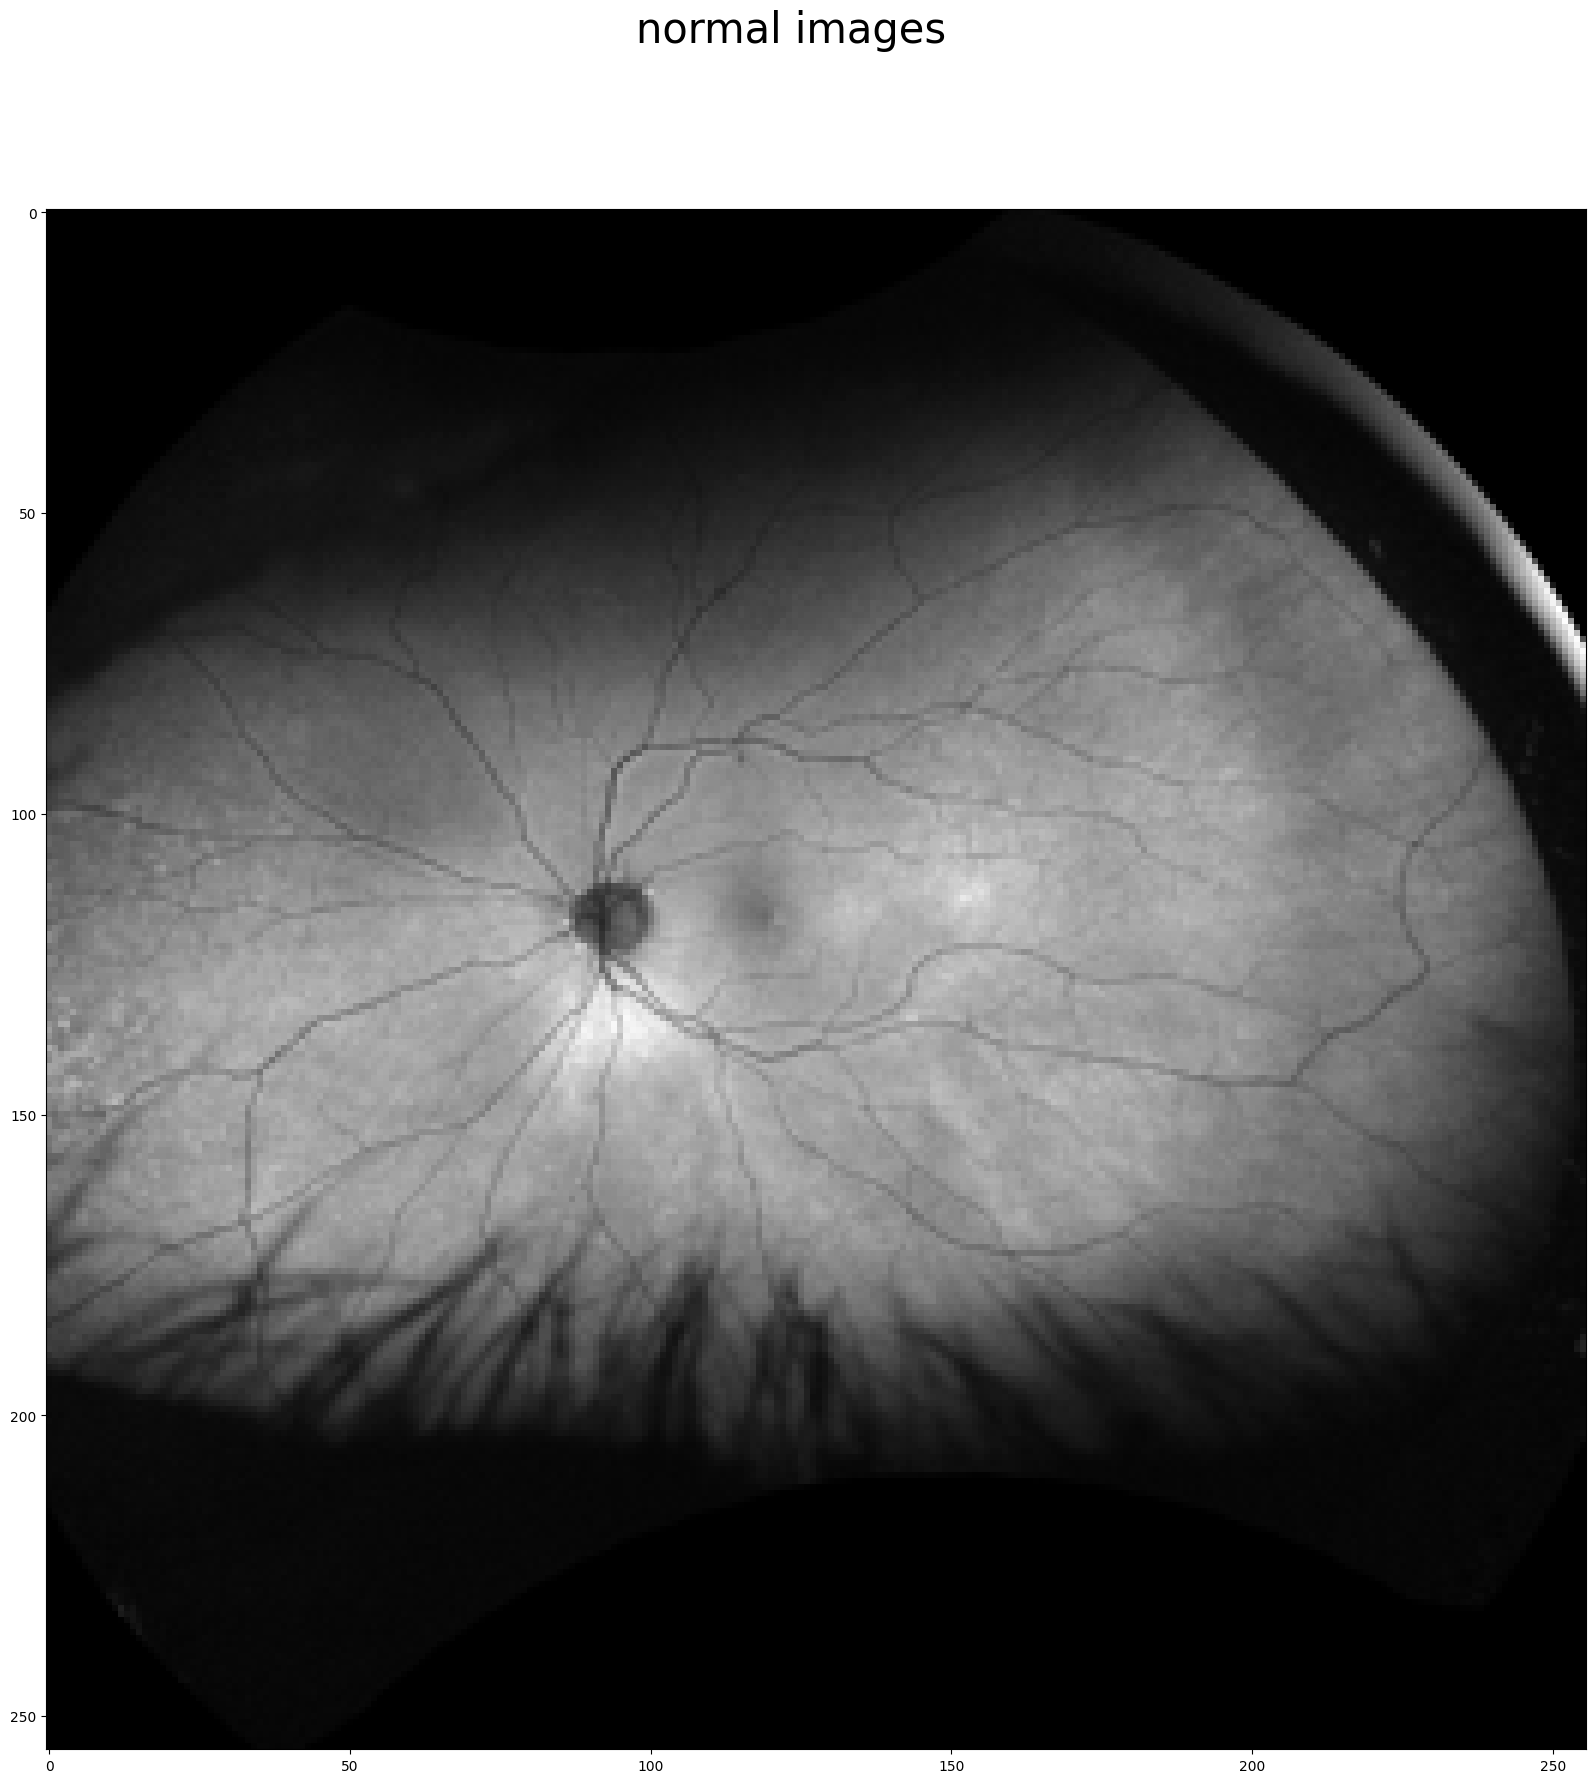

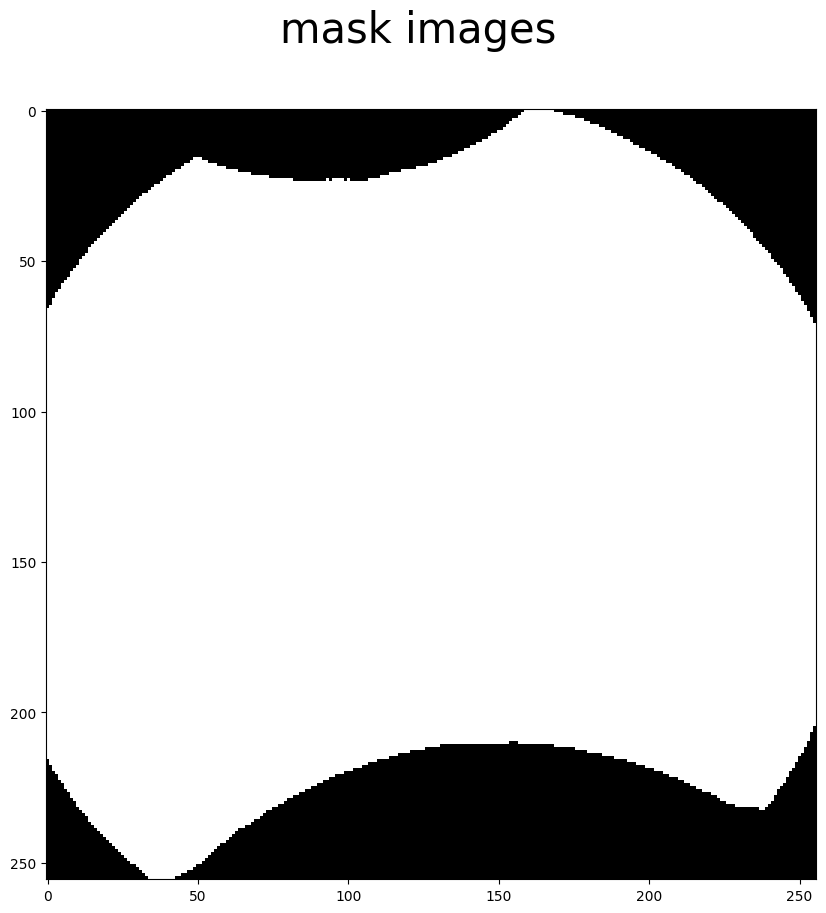

In [8]:
for b in FundusAmyloidPetGenerator.train_loader:
    ddpm_tools.show_images(b["image"],"normal images", show_img=True,gray_scale=True,figdim=20)
    ddpm_tools.show_images(b["mask"],"mask images", show_img=True,gray_scale=True,figdim=10)
    im = b["image"][0]
    break    

# Train ddm

In [9]:
unet = DiffusionModelUNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    attention_levels=(False, True, True),
    num_head_channels=(256)
)
unet.to(FundusAmyloidPetGenerator.device)
scheduler = DDPMScheduler(num_train_timesteps=1000, schedule="linear_beta", beta_start=0.0015, beta_end=0.0195)

In [10]:
scheduler = DDPMScheduler(num_train_timesteps=1000)
optimizer = torch.optim.Adam(params=unet.parameters(), lr=2.5e-5)
inferer = DiffusionInferer(scheduler)

In [11]:
n_epochs = 2
val_interval = -1
epoch_loss_list = []
val_epoch_loss_list = []

scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    unet.train()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(FundusAmyloidPetGenerator.train_loader), total=len(FundusAmyloidPetGenerator.train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(FundusAmyloidPetGenerator.device)
        optimizer.zero_grad(set_to_none=True)

        with autocast(enabled=True):
            # Generate random noise
            noise = torch.randn_like(images).to(FundusAmyloidPetGenerator.device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
            ).long()

            # Get model prediction
            noise_pred = inferer(inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps)

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(FundusAmyloidPetGenerator.val_loader):
            images = batch["image"].to(FundusAmyloidPetGenerator.device)
            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(FundusAmyloidPetGenerator.device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training
        noise = torch.randn((1, 1, 64, 64))
        noise = noise.to(FundusAmyloidPetGenerator.device)
        scheduler.set_timesteps(num_inference_steps=1000)
        with autocast(enabled=True):
            image = inferer.sample(input_noise=noise, diffusion_model=unet, scheduler=scheduler)

        plt.figure(figsize=(2, 2))
        plt.imshow(image[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 0:   0%|          | 1/724 [00:06<1:18:42,  6.53s/it, loss=0.995]


OutOfMemoryError: CUDA out of memory. Tried to allocate 1024.00 MiB (GPU 0; 23.67 GiB total capacity; 11.88 GiB already allocated; 52.56 MiB free; 13.15 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

### save the unet

In [17]:
# torch.save(unet.state_dict(), "autoencoder.pt")

In [13]:
with autocast(enabled=True):
    unet = unet.to(FundusAmyloidPetGenerator.device)
    unet.load_state_dict(torch.load("autoencoder.pt",map_location=FundusAmyloidPetGenerator.device))

## Train the ControlNet

### Set up models

In [14]:
# Create control net
controlnet = ControlNet(
    spatial_dims=2,
    in_channels=3,
    num_res_blocks=2,
    num_channels=(128, 256, 512),
    conditioning_embedding_num_channels = (128,256,512)
    attention_levels=(False, True, True),
    num_head_channels=(0, 256, 512),
    with_conditioning = True,
    conditioning_embedding_in_channels = 1,
    cross_attention_dim = 16,
    num_class_embeds = 2
    
)

# Copy weights from the DM to the controlnet

controlnet.load_state_dict(unet.state_dict(), strict=False)
controlnet = controlnet.to(FundusAmyloidPetGenerator.device)
# Now, we freeze the parameters of the diffusion model.
for p in unet.parameters():
    p.requires_grad = False
    
optimizer = torch.optim.Adam(params=controlnet.parameters(), lr=2.5e-5)

### Run ControlNet training

In [15]:
n_epochs = 1
val_interval = -1
epoch_loss_list = []
val_epoch_loss_list = []
scaler = GradScaler()
total_start = time.time()
for epoch in range(n_epochs):
    unet.train()
    autoencoderkl.eval()
    epoch_loss = 0
    progress_bar = tqdm(enumerate(FundusAmyloidPetGenerator.train_loader), total=len(FundusAmyloidPetGenerator.train_loader), ncols=70)
    progress_bar.set_description(f"Epoch {epoch}")
    for step, batch in progress_bar:
        images = batch["image"].to(FundusAmyloidPetGenerator.device)
        optimizer.zero_grad(set_to_none=True)
        with autocast(enabled=True):
            conditions = batch["label"].to(FundusAmyloidPetGenerator.device).int()
            print(conditions.type())
            masks = batch["mask"].to(FundusAmyloidPetGenerator.device)
            # Generate random noise
            # encode image
            z_mu, z_sigma = autoencoderkl.encode(images)
            z = autoencoderkl.sampling(z_mu, z_sigma)
            noise = torch.randn_like(z).to(FundusAmyloidPetGenerator.device)

            # Create timesteps
            timesteps = torch.randint(
                0, inferer.scheduler.num_train_timesteps, (z.shape[0],), device=z.device
            )
            
            latent_noised = scheduler.add_noise(z, noise=noise, timesteps=timesteps)
            latent_noised = latent_noised.half()
            print(latent_noised.size())
            print(conditions.size())
            print(masks.size())
            
            # Get controlnet output
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=latent_noised.half(), timesteps=timesteps, controlnet_cond=masks.half(), class_labels = conditions
            )
            # cond masks have shape (1,512,512) latent_noised has shape (3,128,128)
            
            # conditionalembedding x cond masks
            # cond embedding has (spatial dims: = spatialdims (2), 
            # in_channels : conditioning_embedding_in_channels
            # num channels : conditioning_embedding_inum_channels (channels for the blocks)
            # out channels: num_channels[0] (attention block channels, predefined )

            # h = self.conv_in(x)  --> (3,128,128) * Convolution() -> (num_channels[0], x, x)
            # convolution takes as input : (in_channels, spatial_dims)

            
            # Get model prediction
            noise_pred = unet(
                x=latent_noised,
                timesteps=timesteps,
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )

            loss = F.mse_loss(noise_pred.float(), noise.float())

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        epoch_loss += loss.item()

        progress_bar.set_postfix({"loss": epoch_loss / (step + 1)})
    epoch_loss_list.append(epoch_loss / (step + 1))

    if (epoch + 1) % val_interval == 0:
        unet.eval()
        val_epoch_loss = 0
        for step, batch in enumerate(FundusAmyloidPetGenerator.val_loader):
            images = batch["image"].to(FundusAmyloidPetGenerator.device)
            conditions = batch["label"].to(FundusAmyloidPetGenerator.device)

            with torch.no_grad():
                with autocast(enabled=True):
                    noise = torch.randn_like(images).to(FundusAmyloidPetGenerator.device)
                    timesteps = torch.randint(
                        0, inferer.scheduler.num_train_timesteps, (images.shape[0],), device=images.device
                    ).long()
                    noise_pred = inferer(inputs=images, diffusion_model=unet, noise=noise, timesteps=timesteps)
                    val_loss = F.mse_loss(noise_pred.float(), noise.float())

            val_epoch_loss += val_loss.item()
            progress_bar.set_postfix({"val_loss": val_epoch_loss / (step + 1)})
            break
        val_epoch_loss_list.append(val_epoch_loss / (step + 1))

        # Sampling image during training with controlnet conditioning
        progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110)
        progress_bar_sampling.set_description("sampling...")
        sample = torch.randn((1, 1, 64, 64)).to(FundusAmyloidPetGenerator.device)
        for t in progress_bar_sampling:
            with torch.no_grad():
                with autocast(enabled=True):
                    down_block_res_samples, mid_block_res_sample = controlnet(
                        x=sample, timesteps=torch.Tensor((t,)).to(FundusAmyloidPetGenerator.device).long(), controlnet_cond=conditions[0, None, ...]
                    )
                    noise_pred = unet(
                        sample,
                        timesteps=torch.Tensor((t,)).to(FundusAmyloidPetGenerator.device),
                        down_block_additional_residuals=down_block_res_samples,
                        mid_block_additional_residual=mid_block_res_sample,
                    )
                    sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)

        plt.subplots(1, 2, figsize=(4, 2))
        plt.subplot(1, 2, 1)
        plt.imshow(conditions[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Conditioning mask")
        plt.subplot(1, 2, 2)
        plt.imshow(sample[0, 0].cpu(), vmin=0, vmax=1, cmap="gray")
        plt.axis("off")
        plt.title("Sample image")
        plt.tight_layout()
        plt.axis("off")
        plt.show()

total_time = time.time() - total_start
print(f"train completed, total time: {total_time}.")

Epoch 0:   0%|                                 | 0/46 [00:04<?, ?it/s]

torch.cuda.IntTensor
torch.Size([4, 3, 128, 128])
torch.Size([4, 1])
torch.Size([4, 1, 512, 512])
c  torch.Size([4, 128, 64, 64])
h:  torch.Size([4, 128, 128, 128])


RuntimeError: The size of tensor a (128) must match the size of tensor b (64) at non-singleton dimension 3

## Sample with ControlNet conditioning
First we'll provide a few different masks from the validation data as conditioning. The samples should respect the shape of the conditioning mask, but don't need to have the same content as the corresponding validation image.

In [ ]:
progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110, position=0, leave=True)
progress_bar_sampling.set_description("sampling...")
num_samples = 8
sample = torch.randn((num_samples, 1, 64, 64)).to(device)

val_batch = first(val_loader)
val_images = val_batch[0].to(device)
val_conditions = val_batch[1].to(device)
for t in progress_bar_sampling:
    with torch.no_grad():
        with autocast(enabled=True):
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=sample, timesteps=torch.Tensor((t,)).to(device).long(), controlnet_cond=val_conditions[:num_samples, ...]
            )
            noise_pred = model(
                sample,
                timesteps=torch.Tensor((t,)).to(device),
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )
            sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)

plt.subplots(num_samples, 3, figsize=(6, 8))
for k in range(num_samples):
    plt.subplot(num_samples, 3, k * 3 + 1)
    plt.imshow(val_conditions[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Conditioning mask")
    plt.subplot(num_samples, 3, k * 3 + 2)
    plt.imshow(val_images[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Actual val image")
    plt.subplot(num_samples, 3, k * 3 + 3)
    plt.imshow(sample[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Sampled image")
plt.tight_layout()
plt.show()

What happens if we invent some conditions? Let's try a circle, and a square

In [ ]:
xx, yy = np.mgrid[:64, :64]
circle = ((xx - 32) ** 2 + (yy - 32) ** 2) < 30**2

square = np.zeros((64, 64))
square[10:50, 10:50] = 1

mask = np.concatenate((circle[None, None, ...], square[None, None, ...]), axis=0)
mask = torch.from_numpy(mask.astype(np.float32)).to(device)


progress_bar_sampling = tqdm(scheduler.timesteps, total=len(scheduler.timesteps), ncols=110, position=0, leave=True)
progress_bar_sampling.set_description("sampling...")
num_samples = 2
sample = torch.randn((num_samples, 1, 64, 64)).to(device)

for t in progress_bar_sampling:
    with torch.no_grad():
        with autocast(enabled=True):
            down_block_res_samples, mid_block_res_sample = controlnet(
                x=sample, timesteps=torch.Tensor((t,)).to(device).long(), controlnet_cond=mask
            )
            noise_pred = model(
                sample,
                timesteps=torch.Tensor((t,)).to(device),
                down_block_additional_residuals=down_block_res_samples,
                mid_block_additional_residual=mid_block_res_sample,
            )
            sample, _ = scheduler.step(model_output=noise_pred, timestep=t, sample=sample)

plt.subplots(num_samples, 2, figsize=(4, 4))
for k in range(num_samples):
    plt.subplot(num_samples, 2, k * 2 + 1)
    plt.imshow(mask[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Conditioning mask")
    plt.subplot(num_samples, 2, k * 2 + 2)
    plt.imshow(sample[k, 0, ...].cpu(), vmin=0, vmax=1, cmap="gray")
    plt.axis("off")
    if k == 0:
        plt.title("Sampled image")
plt.tight_layout()
plt.show()